(sec-dask-case-study)=
# 基于 Dask 的数据分析案例

本节我们将介绍 2个基于 Dask 的数据分析案例。

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client
import pandas as pd

pd.options.mode.chained_assignment = None
# 创建本地集群并连接客户端
cluster = LocalCluster()
client = Client(cluster)

## 案例：自行车数据分析

Citi Bike 数据集提供了纽约市自行车共享系统的详细骑行记录，包括骑行ID、骑行类型、起止时间、起止站点、经纬度和用户类型等信息，用于分析、开发和可视化等多种用途。

我们先读取数据：Citi Bike 数据集由多个 csv 文件组成，每个文件对应一个月份，Dask 可以用通配符 `*` 直接读取多个 csv 文件。

In [2]:
import sys
sys.path.append("..")
from utils import citi_bike

bike_path = citi_bike()
ddf: dd.DataFrame = dd.read_csv(os.path.join(bike_path, "*.csv"))

ddf.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0905B18B365C9D20,classic_bike,2023-01-28 09:18:10,2023-01-28 09:28:52,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735938,-74.030305,40.727596,-74.044247,member
1,B4F0562B05CB5404,electric_bike,2023-01-23 20:10:12,2023-01-23 20:18:27,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Southwest Park - Jackson St & Observer Hwy,HB401,40.735938,-74.030305,40.737551,-74.041664,member
2,5ABF032895F5D87E,classic_bike,2023-01-29 15:27:04,2023-01-29 15:32:38,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Marshall St & 2 St,HB408,40.735944,-74.030383,40.740802,-74.042521,member
3,E7E1F9C53976D2F9,classic_bike,2023-01-24 18:35:08,2023-01-24 18:42:13,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735986,-74.030364,40.727596,-74.044247,member
4,323165780CA0734B,classic_bike,2023-01-21 20:44:09,2023-01-21 20:48:08,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member


接下来对数据进行预处理，包括数据格式转换，数据清洗等。这里我们使用 `map_partitions()` 并行地对每个 Partition 中的数据进行处理，根据每个行程的经纬度、起始时间、结束时间计算平均速度。

In [3]:
def preprocess(df: dd.DataFrame):
    df["started_at"] = dd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"] = dd.to_datetime(df["ended_at"], errors="coerce")

    df["trip_duration"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
    df = df[df["trip_duration"] > 0]

    df["year"] = df["started_at"].dt.year
    df["month"] = df["started_at"].dt.month
    df["day"] = df["started_at"].dt.day
    df["hour"] = df["started_at"].dt.hour

    # 计算速度
    df["distance"] = (
        (df["end_lat"] - df["start_lat"]) ** 2 + (df["end_lng"] - df["start_lng"]) ** 2
    ) ** 0.5
    df["speed"] = df["distance"] / df["trip_duration"]

    df.dropna()
    return df


ddf = ddf.map_partitions(preprocess)
ddf.head()

/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,year,month,day,hour,distance,speed
0,0905B18B365C9D20,classic_bike,2023-01-28 09:18:10,2023-01-28 09:28:52,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735938,-74.030305,40.727596,-74.044247,member,10.700000,2023,1,28,9,0.016248,0.001518
1,B4F0562B05CB5404,electric_bike,2023-01-23 20:10:12,2023-01-23 20:18:27,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Southwest Park - Jackson St & Observer Hwy,HB401,40.735938,-74.030305,40.737551,-74.041664,member,8.250000,2023,1,23,20,0.011473,0.001391
2,5ABF032895F5D87E,classic_bike,2023-01-29 15:27:04,2023-01-29 15:32:38,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Marshall St & 2 St,HB408,40.735944,-74.030383,40.740802,-74.042521,member,5.566667,2023,1,29,15,0.013074,0.002349
3,E7E1F9C53976D2F9,classic_bike,2023-01-24 18:35:08,2023-01-24 18:42:13,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735986,-74.030364,40.727596,-74.044247,member,7.083333,2023,1,24,18,0.016222,0.002290
4,323165780CA0734B,classic_bike,2023-01-21 20:44:09,2023-01-21 20:48:08,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member,3.983333,2023,1,21,20,0.006100,0.001531


下面我们对不同骑行类型的平均速度进行可视化操作。再次提醒，由于 Dask 延迟执行的特性，对数据进行操作后要使用 `compute()` 来触发计算。

/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

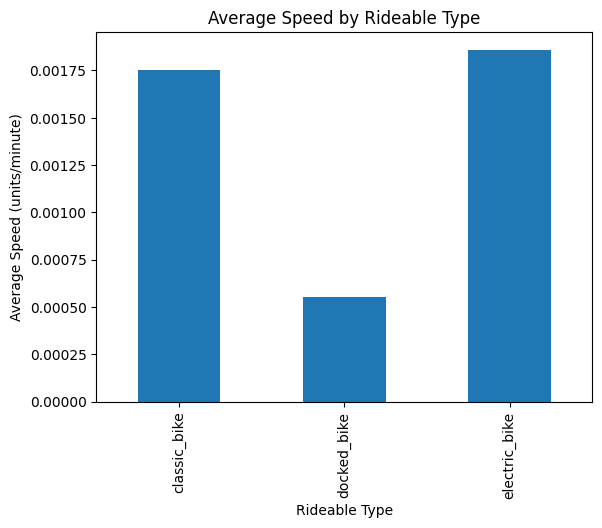

In [4]:
avg_speed_by_type = ddf.groupby('rideable_type')['speed'].mean().compute()
avg_speed_by_type.plot(kind='bar', title='Average Speed by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Average Speed (units/minute)')
plt.show()

接下来我们使用 `groupby()` 对数据进行分组，并进行 `count()`、`sort_values()`、`mean()` 等操作对数据进行处理。

In [5]:
def process_data(df: dd.DataFrame):
    # 按起始站分组的总行程数
    total_rides_by_start_station = (
        df.groupby("start_station_name")["ride_id"].count().compute()
    )
    print("按起始站分组的总行程数:")
    print(total_rides_by_start_station.head())

    # 对起始站分组的数据进行排序
    sorted_trips_by_start_station = total_rides_by_start_station.sort_values(
        ascending=False
    )
    print("\n按总行程数降序排序的起始站:")
    print(sorted_trips_by_start_station.head())

    # 按月份和骑行类型分组的平均行程时长
    trip_duration_by_member_and_month = (
        df.groupby(["month", "rideable_type"])["trip_duration"].mean().compute()
    )
    print("\n按月份和骑行类型分组的平均行程时长:")
    print(trip_duration_by_member_and_month)

    return trip_duration_by_member_and_month


trip_duration_by_member_and_month = process_data(ddf)

/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

按起始站分组的总行程数:
start_station_name
11 St & Washington St                4688
12 St & Sinatra Dr N                 3334
14 St Ferry - 14 St & Shipyard Ln    4100
4 St & Grand St                      2826
5 Corners Library                     938
Name: ride_id, dtype: int64

按总行程数降序排序的起始站:
start_station_name
Grove St PATH                                   12649
Hoboken Terminal - River St & Hudson Pl         12151
South Waterfront Walkway - Sinatra Dr & 1 St     8509
Hoboken Terminal - Hudson St & Hudson Pl         7281
City Hall - Washington St & 1 St                 6503
Name: ride_id, dtype: int64


/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/


按月份和骑行类型分组的平均行程时长:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768713
       electric_bike     12.169278
4      classic_bike      12.316335
       docked_bike      122.971542
       electric_bike     12.398595
Name: trip_duration, dtype: float64


/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

下面我们对按月份和骑行类型分组的平均行程时长进行可视化。

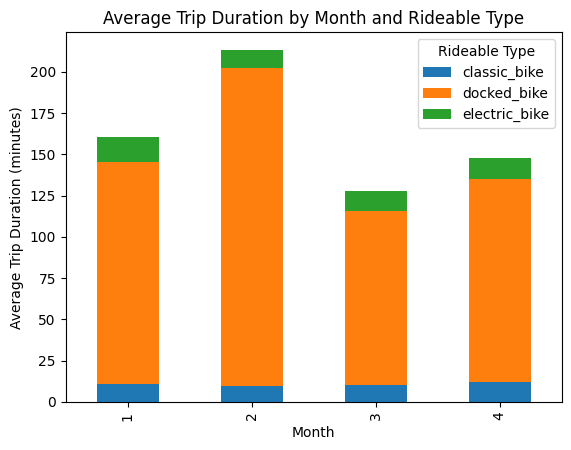

In [6]:
def plot_data(df):
    df.unstack().plot(kind="bar", stacked=True)
    plt.title("Average Trip Duration by Month and Rideable Type")
    plt.xlabel("Month")
    plt.ylabel("Average Trip Duration (minutes)")
    plt.legend(title="Rideable Type")
    plt.show()


plot_data(trip_duration_by_member_and_month)

我们再尝试加入新数据，使用 `concat()` 进行数据的合并和连接，并用相同的方法对合并后的数据进行处理。

In [7]:
from utils import more_citi_bike

bike_path2 = more_citi_bike()
ddf2: dd.DataFrame = dd.read_csv(os.path.join(bike_path2, "*.csv"))

ddf2 = ddf2.map_partitions(preprocess)

concatenated_ddf = dd.concat([ddf, ddf2], axis=0)

trip_duration_by_member_and_month2 = process_data(concatenated_ddf)

/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

按起始站分组的总行程数:
start_station_name
11 St & Washington St                9190
12 St & Sinatra Dr N                 6934
14 St Ferry - 14 St & Shipyard Ln    7830
4 St & Grand St                      5703
5 Corners Library                    1745
Name: ride_id, dtype: int64

按总行程数降序排序的起始站:
start_station_name
Hoboken Terminal - River St & Hudson Pl         23356
Grove St PATH                                   23034
Hoboken Terminal - Hudson St & Hudson Pl        13792
South Waterfront Walkway - Sinatra Dr & 1 St    13727
City Hall - Washington St & 1 St                11791
Name: ride_id, dtype: int64


/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/


按月份和骑行类型分组的平均行程时长:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768713
       electric_bike     12.169278
4      classic_bike      12.316335
       docked_bike      122.971542
       electric_bike     12.398595
10     classic_bike      11.750429
       electric_bike     16.112951
11     classic_bike       9.647373
       electric_bike     10.886656
12     classic_bike       9.715068
       electric_bike     10.103621
Name: trip_duration, dtype: float64


/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/

同样地，进行可视化：

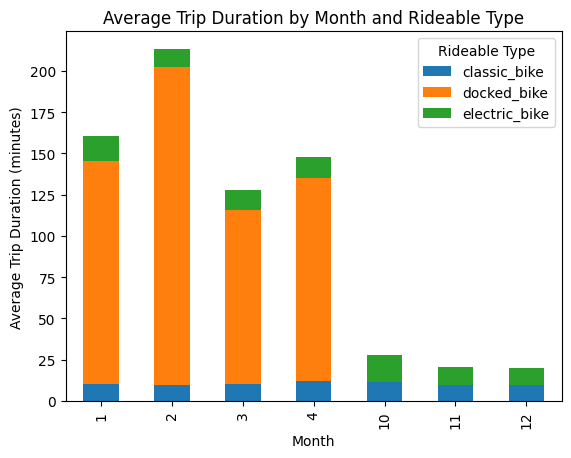

In [8]:
plot_data(trip_duration_by_member_and_month2)

最后尝试建立数据透视表以及数据的可视化。

/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3610548837.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_40900/3

数据透视表:
rideable_type                      classic_bike  docked_bike  electric_bike
start_station_name                                                         
11 Ave & W 27 St                      16.583333          NaN            NaN
11 St & Washington St                  9.993954    20.685897       9.397788
12 St & Sinatra Dr N                  14.230417    38.415351      13.857875
14 St Ferry - 14 St & Shipyard Ln     13.091936   198.055702      15.262149
2 Ave & E 29 St                        7.983333          NaN            NaN
...                                         ...          ...            ...
Warren St                             10.612448    52.636364      11.075977
Washington St                         12.518832   130.303125      11.796525
Washington St & Gansevoort St          3.750000          NaN            NaN
Willow Ave & 12 St                    10.836851    20.166667      11.164558
York St & Marin Blvd                  11.622333    54.966667      25.448760

[161

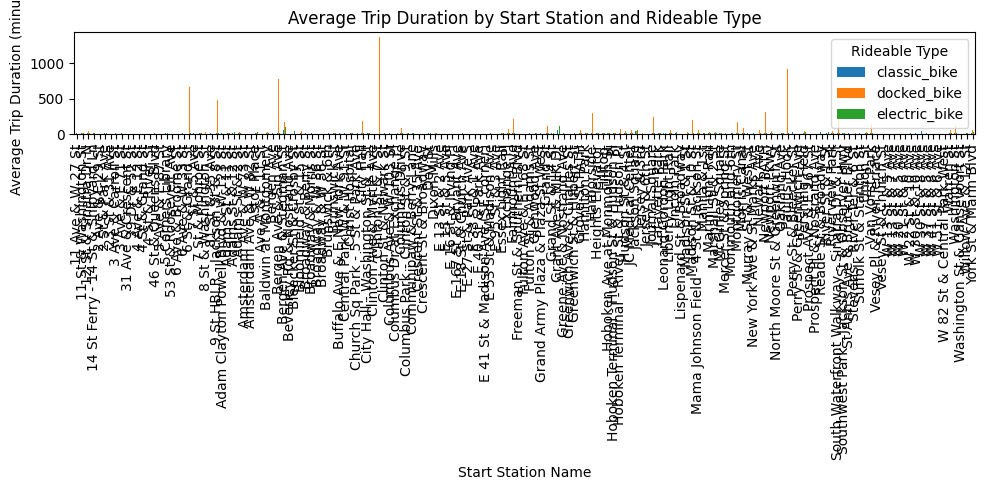

In [9]:
# 将 'rideable_type' 列转换为类别类型
concatenated_ddf["rideable_type"] = concatenated_ddf["rideable_type"].astype("category")
concatenated_ddf = concatenated_ddf.categorize(columns=["rideable_type"])

# 创建数据透视表
pivot_table = concatenated_ddf.pivot_table(
    index="start_station_name",
    columns="rideable_type",
    values="trip_duration",
    aggfunc="mean",
).compute()

print("数据透视表:")
print(pivot_table)

# 可视化数据透视表
pivot_table.plot(kind="bar", figsize=(10, 5))
plt.title("Average Trip Duration by Start Station and Rideable Type")
plt.xlabel("Start Station Name")
plt.ylabel("Average Trip Duration (minutes)")
plt.legend(title="Rideable Type")
plt.tight_layout()
plt.show()

## 案例：人口普查信息

该数据集包含人口统计信息和收入水平的记录，包括年龄、工作类型、教育水平、婚姻状况、职业、种族、性别、每周工作小时数、收入等信息。

我们先读取数据：

In [10]:
from utils import adult
import seaborn as sns

file_path = adult()
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]
adult_ddf: dd.DataFrame = dd.read_csv(
    os.path.join(file_path, "adult.data"), names=columns, header=None
)

adult_ddf.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


下面我们先对数据进行简单的预处理，包括类别类型转换和缺失值处理。

In [11]:
categorical_columns = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

numeric_columns = [
    "age",
    "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]


def preprocess(ddf: dd.DataFrame):
    # 转换必要的列为类别类型
    for col in categorical_columns:
        ddf[col] = ddf[col].astype("category")

    return ddf.dropna()


adult_ddf = adult_ddf.map_partitions(preprocess)

adult_ddf.describe().compute()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


我们先绘制散点图矩阵，想探究收入 `income` 与其余定量变量之间的关系。

<Figure size 1000x1000 with 0 Axes>

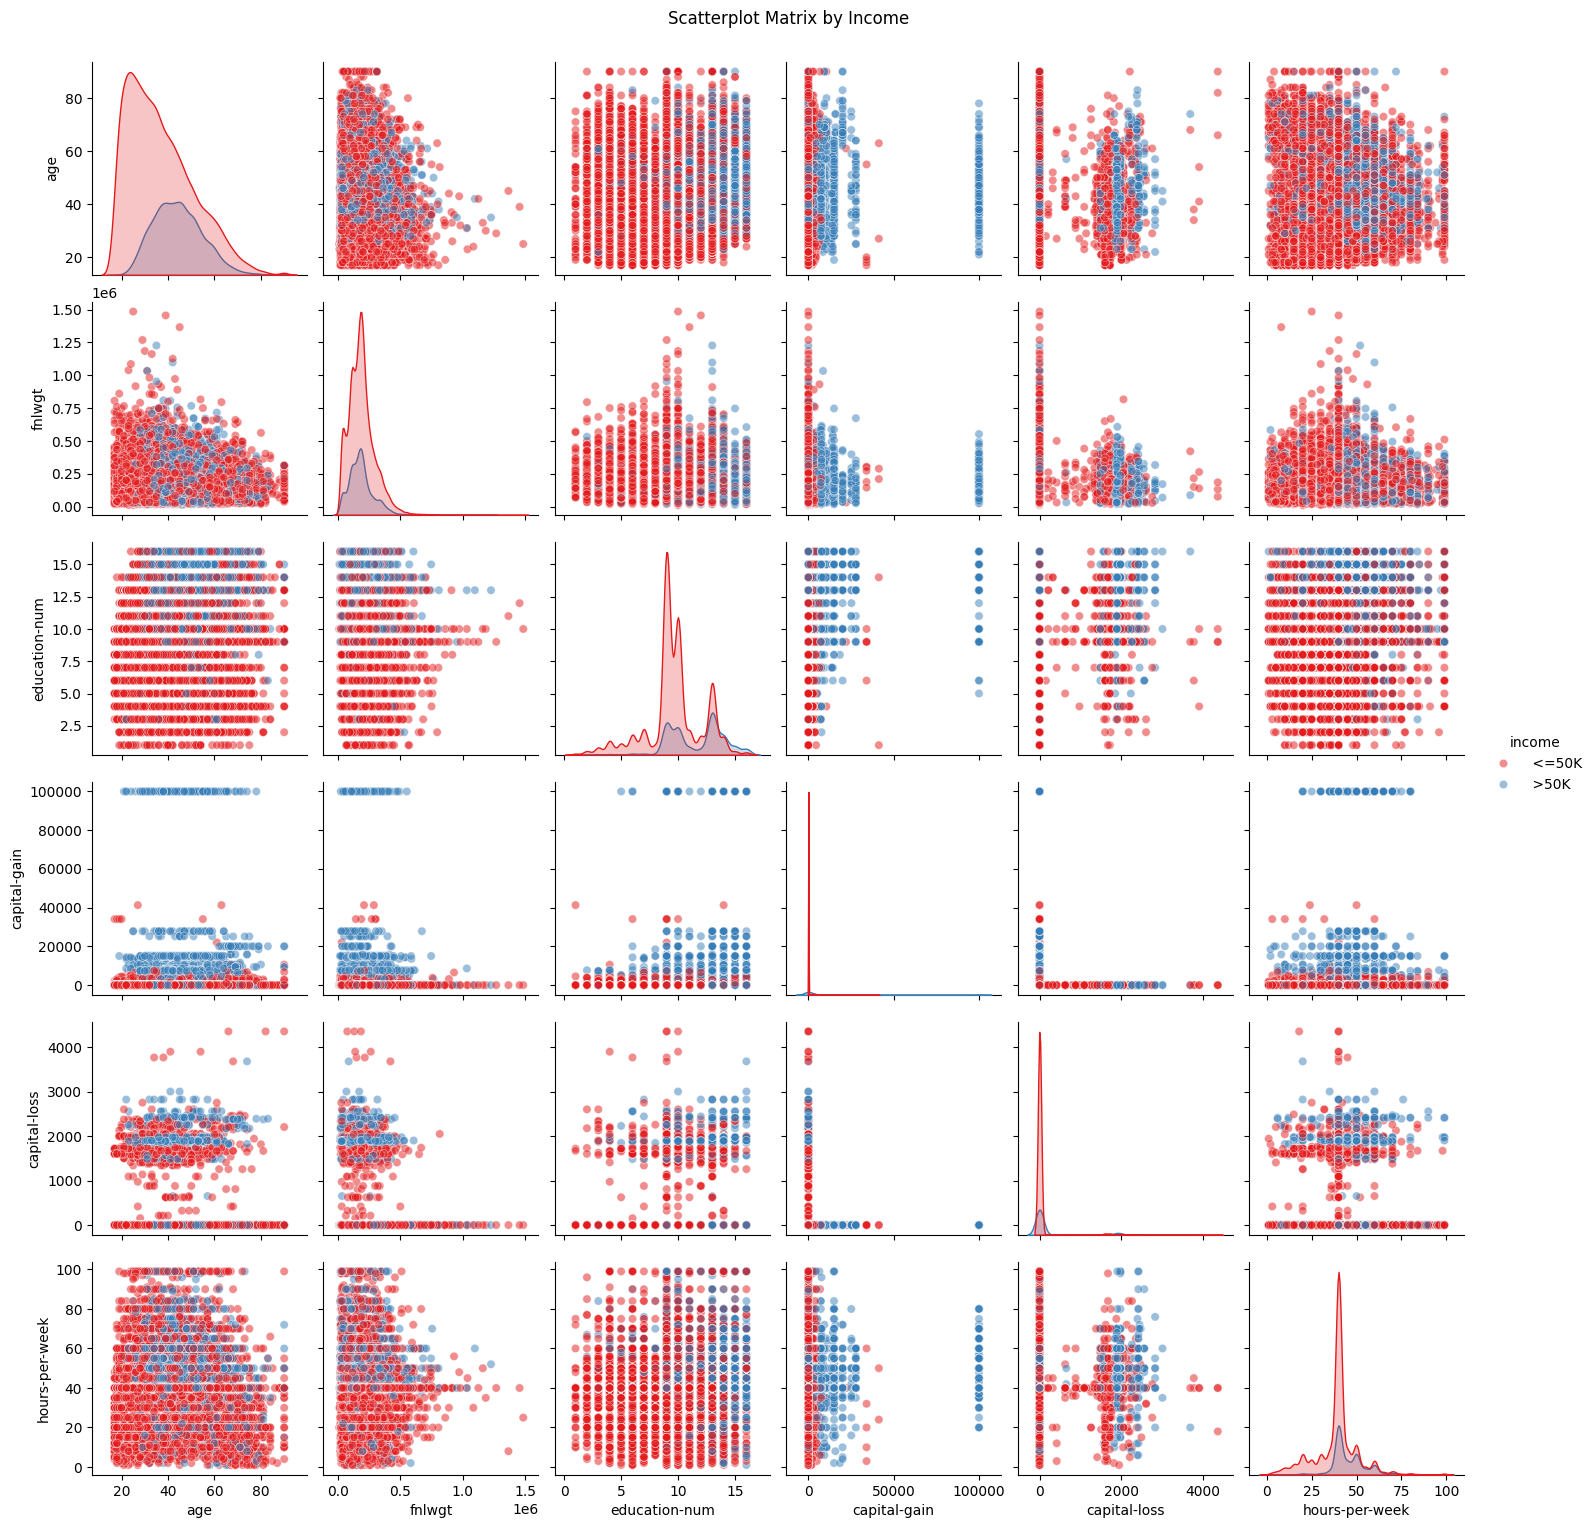

In [12]:
plt.figure(figsize=(10, 10))
sns.pairplot(
    adult_ddf.compute(),
    vars=numeric_columns,
    hue="income",
    palette="Set1",
    plot_kws={"alpha": 0.5},
)
plt.suptitle("Scatterplot Matrix by Income", y=1.02)
plt.show()

结果发现，除了年龄 `age` 以外，其余因素分别在收入 `<=50k` 和 `>50k` 差别不大，因此我们接下来探究年龄与收入之间的关系。

我们使用 `groupby()` 函数，探究在不同的教育程度 `educatin` 的条件下年龄与收入的差异。

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/dataframe/groupby.py:1487: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


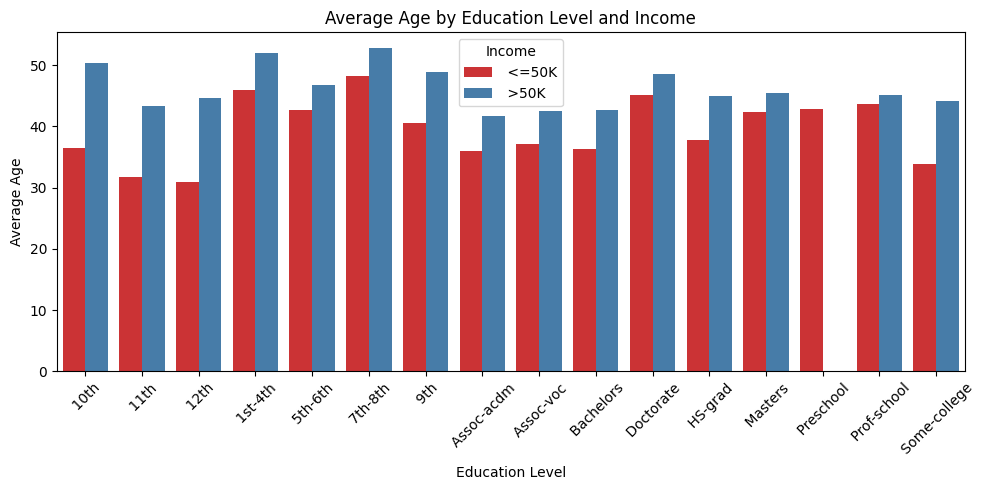

In [13]:
# 按教育程度和收入分组，计算平均年龄
education_income_age = (
    adult_ddf.groupby(["education", "income"])["age"].mean().reset_index().compute()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=education_income_age, x="education", y="age", hue="income", palette="Set1"
)
plt.xticks(rotation=45)
plt.title("Average Age by Education Level and Income")
plt.xlabel("Education Level")
plt.ylabel("Average Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

结果显示，无论什么教育程度，收入 `>=50k` 人群的平均年龄均偏高，集中在 40 到 50 岁之间。

接着我们想探究在更具体的教育年数 `education_num` 下，年龄与收入之间的关系。

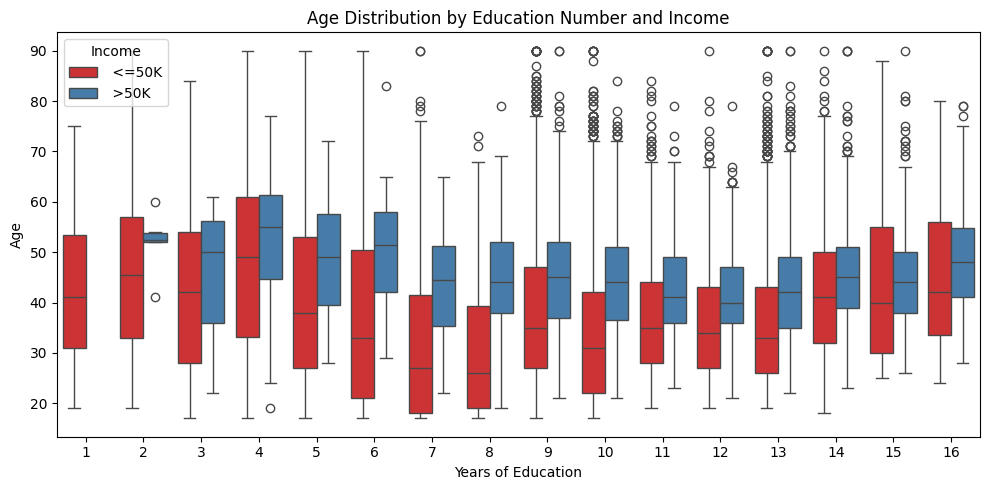

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/dataframe/groupby.py:1487: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/dataframe/groupby.py:430: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(level=levels, sort=sort, **observed, **dropna)


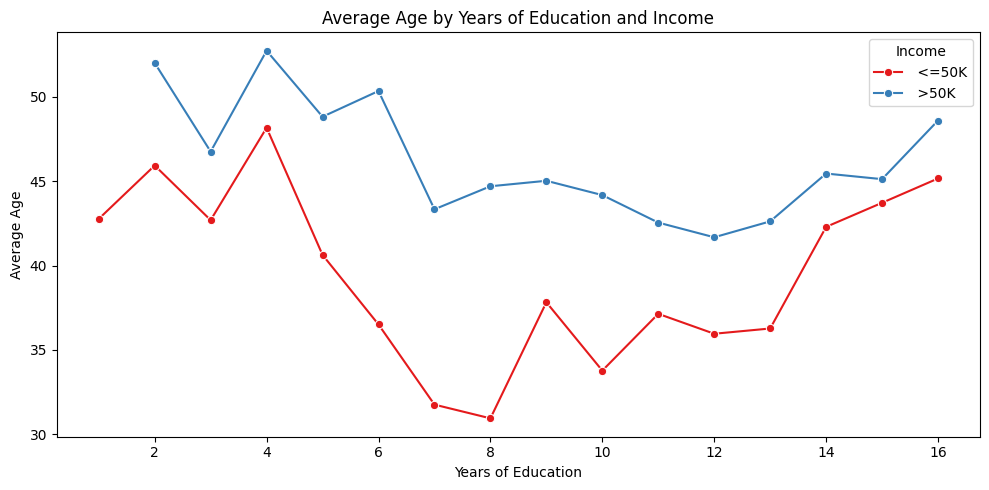

In [14]:
# 探究教育年数与收入之间的关系
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=adult_ddf.compute(), x="education-num", y="age", hue="income", palette="Set1"
)
plt.title("Age Distribution by Education Number and Income")
plt.xlabel("Years of Education")
plt.ylabel("Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

# 按教育年数和收入分组，计算平均年龄
education_num_income_age = (
    adult_ddf.groupby(["education-num", "income"])["age"].mean().reset_index().compute()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=education_num_income_age,
    x="education-num",
    y="age",
    hue="income",
    marker="o",
    palette="Set1",
)
plt.title("Average Age by Years of Education and Income")
plt.xlabel("Years of Education")
plt.ylabel("Average Age")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

结果显示，随着教育年数的增加，收入 `>50K` 的个体年龄中位数和均值都逐渐增加，但两组之间的差异逐渐减小。

最后我们不同教育程度与平均时薪之间的关系。我们首先要对数据再进行处理，计算出平均时薪。

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/dataframe/groupby.py:1487: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


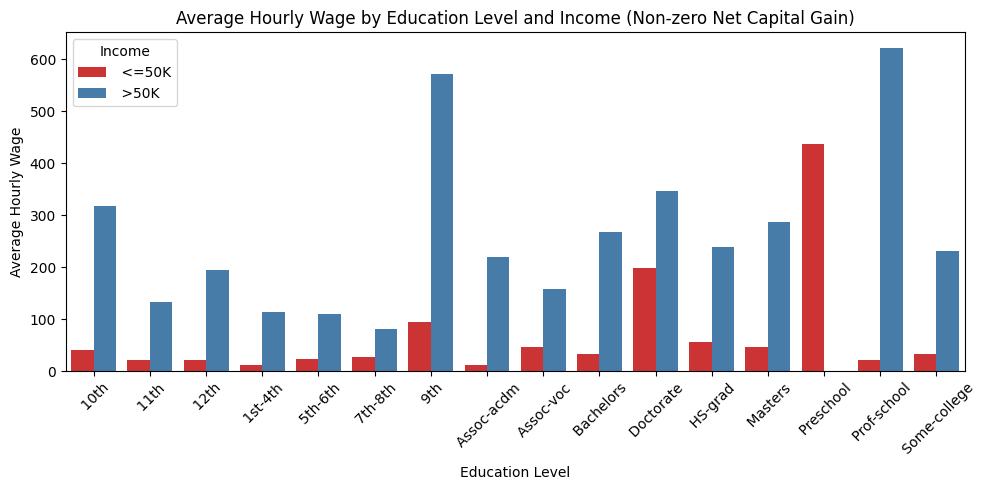

In [15]:
def calc_avg_income(df):
    df["net_capital_gain"] = df["capital-gain"] - adult_ddf["capital-loss"]
    df = df[df["net_capital_gain"] != 0]
    df["hourly_wage"] = df["net_capital_gain"] / df["hours-per-week"]

    return df


adult_ddf = calc_avg_income(adult_ddf)
# 按教育程度和收入分组，计算平均时薪
education_income_wage = (
    adult_ddf.groupby(["education", "income"])["hourly_wage"]
    .mean()
    .reset_index()
    .compute()
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=education_income_wage,
    x="education",
    y="hourly_wage",
    hue="income",
    palette="Set1",
)
plt.xticks(rotation=45)
plt.title(
    "Average Hourly Wage by Education Level and Income (Non-zero Net Capital Gain)"
)
plt.xlabel("Education Level")
plt.ylabel("Average Hourly Wage")
plt.legend(title="Income")
plt.tight_layout()
plt.show()

低教育程度的人群中，收入 `>50K` 的个体平均时薪远高于收入 `<=50K` 的个体。随着教育程度的增加，收入 `>50K` 和收入 `<=50K` 之间的时薪差距依然明显，但在高等教育程度中，这种差距显著缩小。然而，收入 `>50K` 的个体平均时薪依然高于收入 `<=50K` 的个体。

总体而言，教育程度对收入的影响显著，不同教育程度下的个体平均时薪差异明显，特别是收入 `>50K` 的个体，其平均时薪随着教育程度的提升而显著增加。

In [16]:
client.shutdown()